In [1]:
# Import the pandas package, then use the "read_csv" function to read
# the labeled training data
import pandas as pd
from bs4 import BeautifulSoup             
import re
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

train = pd.read_csv("./all/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)
train = train.drop(['id'], axis=1)
train.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


### 加入自行IMDB爬去取的文章與評價

In [4]:
df2 = pd.read_csv('./all/imdb_master.csv',encoding="latin-1")
df2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [5]:
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [6]:
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [7]:
training = pd.concat([train, df2]).reset_index(drop=True)
training.shape

(75000, 2)

In [8]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review,).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

In [9]:
# Get the number of reviews based on the dataframe column size
num_reviews = training["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 10000, print a message
    if( (i+1)%10000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews ))                                                                 
    clean_train_reviews.append( review_to_words( training["review"][i] ))
print("Done")

Cleaning and parsing the training set movie reviews...



/Users/liouscott/anaconda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/liouscott/anaconda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Review 10000 of 75000

Review 20000 of 75000

Review 30000 of 75000

Review 40000 of 75000

Review 50000 of 75000

Review 60000 of 75000

Review 70000 of 75000

Done


### 透過 CountVectorizer將詞轉為矩陣

In [10]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000) 

# The input to fit_transform should be a list of strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()
print ("Done")

Creating the bag of words...

Done


### 使用文字雲

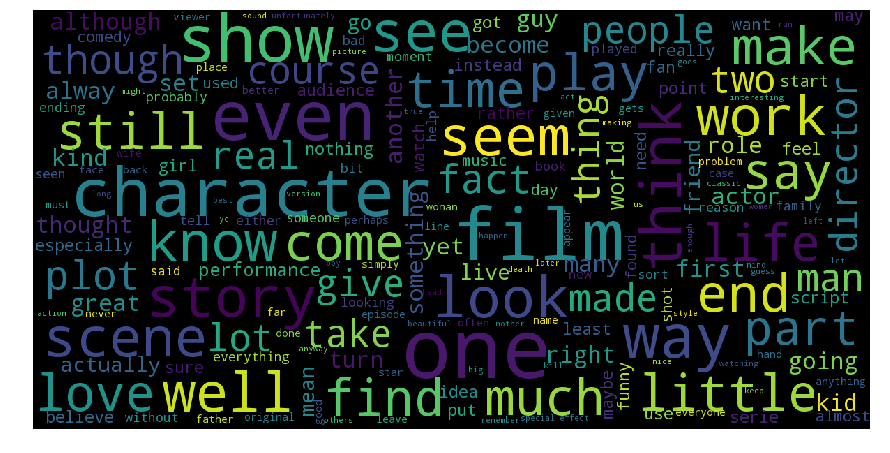

In [12]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(clean_train_reviews)

In [13]:
#splitting dataset into training and testing data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_data_features,training["sentiment"],test_size=0.2,random_state=0)
print("Splitting Done")

Splitting Done


### 使用RandomForest

In [16]:
print ("Training the random forest model...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(x_train, y_train )
print ("Done")

Training the random forest model...
Done


In [17]:
# Use the random forest to make sentiment label predictions
result = forest.predict(x_test)
print("Predictions Done")

Predictions Done


In [18]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
#checking accuracy score
accuracy=accuracy_score(y_test,result)
accuracy

0.933

In [19]:
#checking confusion matrix
cm=confusion_matrix(y_test,result)
cm

array([[7011,  472],
       [ 533, 6984]])

In [20]:
#checking f1 score
f1=f1_score(y_test,result)
f1

0.9328791825285514

In [21]:
from nltk.corpus import stopwords # Import the stop word list

# Read the test data
test = pd.read_csv("./all/testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print (test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print ("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
    if( (i+1) % 5000 == 0 ):
        print ("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_to_words( test["review"][i] )
    clean_test_reviews.append( clean_review )

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv("Bag_of_Words_model.csv", index=False, quoting=3 )
print("Done")

(25000, 2)
Cleaning and parsing the test set movie reviews...



/Users/liouscott/anaconda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/liouscott/anaconda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Review 5000 of 25000

Review 10000 of 25000

Review 15000 of 25000

Review 20000 of 25000

Review 25000 of 25000

Done
